# Inventing Fashion with Generative Adversarial Networks

**Generative Adversarial Networks (GANs)** are an incredible AI model for generating photo-realistic images. 

Here are a few examples of GAN-created images! **What could the training data be in each case?**

![](https://www.tensorflow.org/images/gan/dcgan.gif)
![](https://miro.medium.com/max/700/1*Kv92xPy9bpdtSg6TsMI8Pg.png)
![](https://raw.githubusercontent.com/NVlabs/stylegan/master/stylegan-teaser.png)
![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-Object-Transfiguration-from-Apples-to-Oranges-and-Oranges-to-Apples.png)

You might have also heard of **deepfakes**, a hugely ethically challening application of GANs!


A few fun GAN games and demos to play around with on your own:
*   https://www.whichfaceisreal.com/ 
*   https://affinelayer.com/pixsrv/ 
*   https://www.nvidia.com/en-us/research/ai-playground/ 

In this combo lecture/notebook, we'll be creating and training GANs to invent new fashion. We'll discuss the main ideas of GANs and create small images - play around on your own to make them bigger and better! 



### Preparing our data

Let's quickly prepare some data and packages.

In [1]:
#@title Run this to load some packages and functions!
import tensorflow as tf
!pip install imageio
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
from mpl_toolkits.axes_grid1 import ImageGrid
from itertools import islice
from IPython import display


def show_dataset_examples(ds):
  grid = ImageGrid(plt.figure(), 111, nrows_ncols=(4, 4), axes_pad = 0.1)
  for index, img in islice(enumerate(ds),16):
    grid[index].imshow((img+1)/2, cmap = 'Greys')
  plt.show()


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

def train(dataset, epochs):

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
def scale_and_show(img):
  plt.imshow(np.array(img[:,:,0]), cmap = "Greys")

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      scale_and_show(predictions[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show() 

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

Our GAN will learn to create fashion photos using the Fashion MNIST dataset. Let's load it in and take a look:

4423680/4422102 [==============================] - 0s 0us/step


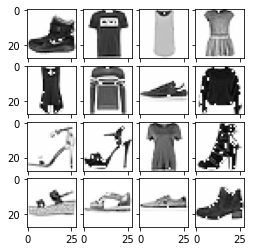

(60000, 28, 28) 3


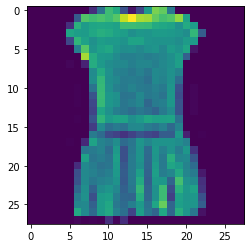

In [2]:
index = 3
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
show_dataset_examples(train_images)
plt.imshow(train_images[index])
print (train_images.shape, train_labels[index])

**Discuss:**
*   What's the size of the images and dataset?
*   How would you describe the images in our dataset?
*   How will you know if our GAN does a good job of creating new images?


To preprocess our data, we'll need to do a couple of things. First, let's reshape it to four dimensions - what does the last dimension represent?

In [ ]:
print (train_images.shape)
train_images_reshaped = np.expand_dims(train_images, 3)
print (train_images_reshaped.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


Next, let's do some arithmetic to scale the data from a range of [0 to 255] to a range of [-1 to 1], which helps make training faster. **Challenge**: can you do this calculation a different way?

In [ ]:
print (train_images_reshaped.min(), train_images_reshaped.max())
half_range = (train_images_reshaped.max() - train_images_reshaped.min())/2 
train_images_scaled = (train_images_reshaped - half_range)/half_range
print (train_images_scaled.min(), train_images_scaled.max())

0 255
-1.0 1.0


## GAN Overview

Now, let's talk about how GANs work! 

The core idea is clever but surprisingly simple: we make two neural networks fight each other!

The **generator** is like an **art forger**: its job is to create realistic-looking fake images. 

The **discriminator** is like a **detective**: its job is to tell the difference between **fake** images created by the generator and **real** images from the training data.

![](https://www.tensorflow.org/tutorials/generative/images/gan1.png) 

Both networks start out terrible at their jobs - but over time, they push each other to get better! The discriminator gets better at telling the generator's images from the real deal, and the generator has to make more realistic fake images so it can trick the discriminator.

The generator **never** sees the training data, so it has to invent brand-new images rather than copying existing ones!

![](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

## Building Our Models

Let's prepare a few hyperparameters - you can experiment with changing these later!

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMG_SIZE = 28
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
generator_lr = .0001
discriminator_lr = .0001

### Discriminator
Let's start by creating our discriminator. It's a pretty standard CNN for image classification: it takes an image as input and produces an output from 0 ("definitely fake!") to 1 ("definitely real!"). Here's a visualization of one discriminator structure:

![](https://miro.medium.com/max/700/1*ad8tUoJx7U3tfMDRcs0MGg.jpeg)

We'll have a few convolutional layers followed by a fully-connected layer. Below, please add the missing layers, including dropout (recommended: 0.3) so that the discriminator doesn't memorize the training data!

In [ ]:
def make_discriminator_model():

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMG_SIZE, IMG_SIZE, 1]))
    #TODO: Fill in input_shape above
    
    model.add(layers.LeakyReLU())
    #TODO: Add dropout here
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    #TODO: Add dropout here
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    #TODO: Add final Dense layer here - how many outputs?
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Let's try out our (untrained) disciminator on an image from the training data! Did it guess correctly? Does the structure match what you expected?

In [ ]:
discriminator = make_discriminator_model()
print (discriminator.summary())

decision = discriminator.predict(train_images_scaled[:1])
print()
print ("Prediction for image from training data:", decision)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

### The Generator
Now, the generator's a little more complicated. Its input is just some random numbers, so that it doesn't always produce the same output. Its output is an image! 

So it has the opposite structure of the discriminator: it goes from a small-dimensional input to a large-dimensional output. We'll do this using upsampling (transpose convolution) layers, which you might remember from U-Net! The bigger the stride, the bigger the output.

Here's an example of a GAN structure:

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Example-of-the-Generator-Model-Architecture-for-the-DCGAN.png)







In the code below, fill in the blanks to complete the layers and identify the correct output shapes. **Hint:** as you work, try running the cell after to see if you've passed the assertions!

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 
    # The assert line shows the expected output shape at this stage. None is the batch size
    # Hint: What does layers.Reshape() do?

    # conv2d(128, (5,5),strides=(1,1),...) -> (28, 28, 128)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    # Hint: What shape is the image at this point? How many filters does the most recent layer have?
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # conv2d(64)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    # Hint: How and why has our image shape changed?
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1) # What is the desired output size for the whole generator? (Hint: You might have to scroll up!)

    return model

You can use the (untrained) generator to create an image! Does it look like fashion yet?

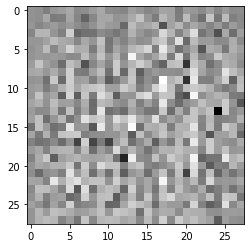

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)        

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

scale_and_show(generated_image[0])
plt.show()

print(generator.summary())

## Defining Loss
One last thing before training: we need to define each network's **loss** to measure how well it's doing. We'll use cross-entropy, which measures how different two arrays are. [0, 0, 0] and [0, 0, 0.1] have low cross-entropy, while [0, 0, 0] and [0.9, 1, 0.9] have high cross-entropy.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

###Disciminator Loss
Let's start with the discriminator! If it did its job perfectly, 
*    its outputs for real images would be all 1s
*   its outputs for fake (generated) images would be all 0s

Let's see how well its outputs match those goals! To get the total loss, we can combine real and fake loss.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    #YOUR CODE HERE to compute fake_loss and total_loss
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    #END CODE
    return fake_loss+real_loss

###Generator Loss

The generator's job is to trick the disciminator, so we have to use the disciminator to measure its success.

If the generator works perfectly, then the disciminator's output for the fake images will be all 1s! 

Calculate the generator's loss below:


In [ ]:
def generator_loss(disc_fake_output):
    #YOUR CODE HERE to calculate loss using cross_entropy
    loss = cross_entropy(tf.ones_like(disc_fake_output), disc_fake_output)
    #END CODE
    return loss 

The discriminator and the generator optimizers are different since we will train two networks separately.

## Training the model
Finally, we can train our models! We'll train the generator and disciminator at the same time and watch the images improve.

Training GANs is notoriously tricky - they're very sensitive to hyperparameters, and we need the generator and disciminator to train at similar rates so they don't overpower each other!

Let's prepare our optimizers, data, and generator input:

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(generator_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(discriminator_lr)

#We'll reuse input to the generator in our GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim]) 

#Packaging up our training images as a Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Here's the function we'll use at each step of training! What does each line do?

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #Make images:
      generated_images = generator(noise, training=True)

      #Get the discriminator's output:
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      #Calculate each network's loss:
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    #Update each network's weights to (hopefully) reduce the loss next time:
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


Finally, let's train! How many epochs does it take to get good results? Do you notice any interesting patterns?

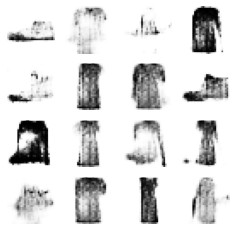

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
#@title If you'd like, run this to download a GIF of your model's training!

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion 

Congratulations - you've generated new fashion photos that don't exist anywhere! Can you imagine an AI creating entire fashion designs?

As a next step, **try experimenting with the hyperparameters and architectures** to generate high-quality images. 

And give some thought to the ethical questions around GANs:
*  Who gets the credit if an AI invents or designs something new?
*  How can human and AI creativity work together?
*  What are the dangers of GANs that can generate super-realistic photos and videos, including deepfakes featuring real people?

Acknowledgements: Parts of this notebook were adapted from https://www.tensorflow.org/tutorials/generative/dcgan, which includes license information. Check out more GAN tutorials at that link!
